In [1]:
import matplotlib.pyplot as plt

In [36]:
%matplotlib inline

# YOLO 

En aquesta sessió descobrirem un dels models de l'estat de l'art (SOTA) de l'Aprenentatge Automàtic.

You Only Look Once: Unified, Real-Time Object Detection. [article](https://arxiv.org/pdf/1506.02640) ; [presentació](https://www.youtube.com/watch?v=NM6lrxy0bxs&pp=ygUkeW91IG9ubHkgbG9vayBvbmNlIHByZXNlbnRhdGlvbiBjdnBy)

YOLO (You Only Look Once) és una arquitectura de xarxa neuronal profunda inicialment dissenyada per a la detecció d'objectes en imatges en temps real. A diferència d'altres enfocaments que processen les imatges en diverses etapes com per exemple la família R-CNN. YOLO adopta un enfocament unificat: divideix la imatge en una quadrícula i processa cada cel·la simultàniament per predir les bounding boxes i les classes dels objectes presents. Aquesta integració permet assolir una velocitat notable sense comprometre significativament la precisió. A més, gràcies al seu disseny optimitzat, YOLO ha estat modificada i adaptada per realitzar múltiples tasques relacionades amb la visió per computador. Actualment pot: classificar, detectar, segmentar, seguiment d'objectes a vídeo, seguiment dels moviments del cos.

### YOLO: Una breu història

- **YOLO (You Only Look Once)**, un model popular de detecció d'objectes i segmentació d'imatges, va ser desenvolupat per Joseph Redmon i Ali Farhadi a la Universitat de Washington. Llançat el 2015, YOLO va guanyar ràpidament popularitat per la seva alta velocitat i precisió.
- **YOLOv2**, llançat el 2016, va millorar el model original incorporant _batch normalization_ i  _anchor boxes_.
- **YOLOv3**, llançat el 2018, va millorar encara més el rendiment del model mitjançant un _backbone_ més eficient, múltiples  _anchor boxes_ i agrupació de piràmides espacials (objectes de múltiples mides).
- **YOLOv4** es va llançar el 2020, introduint innovacions com l'augment de dades emprant mosaics, un nou capçal (_head_) de detecció i una nova funció de pèrdua.
- **YOLOv5** va millorar encara més el rendiment del model i va afegir noves funcions com ara l'optimització d'hiperparàmetres, el seguiment d'experiments integrat i l'exportació automàtica a formats d'exportació populars. [**Controvèrsia!!**](https://blog.roboflow.com/yolov4-versus-yolov5/)
- **YOLOv6** va ser de codi obert per [Meituan](https://github.com/meituan/YOLOv6) el 2022 i s'utilitza en molts dels robots de lliurament autònoms de la companyia.
- **YOLOv7** va afegir tasques addicionals, com ara l'estimació de poses (_pose estimation_) al conjunt de dades de punts clau COCO.
- **YOLOv8** Es basa en l'èxit de les versions anteriors, introduint noves funcions i millores per millorar el rendiment, la flexibilitat i l'eficiència. YOLOv8 admet una gamma completa de tasques d'IA de visió, com ara detecció, segmentació, estimació de poses, seguiment i classificació. Aquesta versatilitat permet als usuaris aprofitar les capacitats de YOLOv8 en diferents aplicacions i dominis. --> Propaganda Ultralytics ^^.
- **YOLOv9**, **YOLOv10**, **YOLOv11** : Successives millores en la xarxa, sobretot enfocades a mantenir les seves capacitats reduïnt la seva mida.

Per començar i fer les primeres proves es recomana usar la versió 5, a que té un bon equilibri entre dificultat (complicacions d'ús) i els resultats que podem obtenir.


## Arquitectura

La xarxa té 24 capes convolucionals seguides de 2 capes completament connectades. En lloc dels mòduls inicials utilitzats per [GoogLeNet](https://arxiv.org/pdf/1409.4842), per reduir el mapes d'activació s'utilitzen capes convolucionals 1×1 seguides de capes convolucionals de 3×3.

![YOLO](img/YOLO.png "YOLO")


### Detecció unificada

A diferència de les xarxes que provenen de R-CNN a l'article s'explica:

> Unifiquem els components separats de la detecció d'objectes en una única xarxa neuronal. La nostra xarxa utilitza funcions
de tota la imatge per predir cada quadre delimitador. També prediu tots els quadres delimitadors (_bounding boxes_) de totes les classes per a una imatge simultàniament. Això vol dir que la nostra xarxa raona globalment sobre la imatge completa i tots els objectes de la imatge.

El sistema YOLO divideix la imatge d'entrada en una graella $S×S$. Si el centre d'un objecte cau dins d'una cel·la de quadrícula, aquesta cel·la de quadrícula s'encarrega de detectar aquest objecte. Cada cel·la de la quadrícula prediu $B$ quadres de delimitació i els valors de confiança per a aquestes caixes. 

Aquestes puntuacions de confiança reflecteixen la confiança que té el model que la caixa conté un objecte i també la precisió que creu que és la caixa que prediu. Cada quadre delimitador consta de 5 prediccions: $x, y, w, h$ i la confiança. Les coordenades $(x, y)$ representen el centre del quadre en relació amb els límits de la cel·la de la quadrícula. L'amplada i l'alçada es prediuen en relació amb tota la imatge. Finalment, la predicció de confiança representa l'IOU entre la caixa predita i qualsevol caixa de veritat terrestre. Cada cel·la de la quadrícula també prediu probabilitats de classe condicional $C$.


![YOLO](img/YOLO_deteccio.png "YOLO")

L'arquitectura que hem mostrat anteriorment té una capa de sortida de $7x7x30$ degut a que  la sortida és correspon amb la següentv fórmula: $S × S × (B ∗ 5 + C)$ en el cas de l'article original: $S=7$, $B=2$ i $C=20$ ja que es va entrenar amb el dataset [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/).

Actualment l'arquitectura de la xarxa és molt més complexa, i inclou 3 blocs molt diferenciats:

- **Columna** "Backbone": Bàsicament és una xarxa convolucional que extreu característiques. A partir de la versió 3 creen la seva pròpia xarxa anomenada DarkNet, un model amb connexions residuals que té al voltant de 53 capes.
- **Coll**: Aquesta part connecta la columna i el/els caps. S'encarrega entre d'altres coses de la detecció d'objectes a múltiples escales mitjançant xarxes piramidals que reben informació de diversos punts del "Backbone.
- **Cap**: El cap/caps s'encarrega de fer prediccions. En les versions modernes de YOLO s'utilitzen múltiples mòduls de detecció que prediuen quadres delimitadors, puntuacions d'objectivitat i probabilitats de classe per a cada cel·la de quadrícula del mapa de característiques. A continuació, aquestes prediccions s'agreguen per obtenir les deteccions finals.

Podem veure un exemple d'aquesta complexa arquitectura en el següent enllaç a la documentació oficial de la [YOLO v5](https://docs.ultralytics.com/yolov5/tutorials/architecture_description/#1-model-structure).

## Ús de la xarxa

La manera més senzilla d'emprar la xarxa és desde la llibreria que la empresa Ultralytics ens ofereix. D'aquesta manera ens és molt senzill poder provar les diferents versions de la xarxa i també realitzar els processos de _fine tunning_ o de _transfer learning_.

In [2]:
#!pip install -U ultralytics

   ---------------------------------------- 0.0/904.3 kB ? eta -:--:--
   ---------------------------------------- 904.3/904.3 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   --------------- ------------------------ 2.4/6.2 MB 11.2 MB/s eta 0:00:01
   ------------------------------ --------- 4.7/6.2 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


Començarem fent proves amb la YoloV5 que presenta 5 versions diferents, cada una d'aquestes versions té una xarxa _backbone_ de mida diferent, a més tenim 2 mides d'entrada d'imatges:

<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>size<br><sup>(pixels)</sup></th>
      <th>mAP<sup>val<br>50-95</sup></th>
      <th>mAP<sup>val<br>50</sup></th>
      <th>Speed<br><sup>CPU b1<br>(ms)</sup></th>
      <th>Speed<br><sup>V100 b1<br>(ms)</sup></th>
      <th>Speed<br><sup>V100 b32<br>(ms)</sup></th>
      <th>params<br><sup>(M)</sup></th>
      <th>FLOPs<br><sup>@640 (B)</sup></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n.pt" target="_blank">YOLOv5n</a></td>
      <td>640</td>
      <td>28.0</td>
      <td>45.7</td>
      <td><strong>45</strong></td>
      <td><strong>6.3</strong></td>
      <td><strong>0.6</strong></td>
      <td><strong>1.9</strong></td>
      <td><strong>4.5</strong></td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt" target="_blank">YOLOv5s</a></td>
      <td>640</td>
      <td>37.4</td>
      <td>56.8</td>
      <td>98</td>
      <td>6.4</td>
      <td>0.9</td>
      <td>7.2</td>
      <td>16.5</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5m.pt" target="_blank">YOLOv5m</a></td>
      <td>640</td>
      <td>45.4</td>
      <td>64.1</td>
      <td>224</td>
      <td>8.2</td>
      <td>1.7</td>
      <td>21.2</td>
      <td>49.0</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5l.pt" target="_blank">YOLOv5l</a></td>
      <td>640</td>
      <td>49.0</td>
      <td>67.3</td>
      <td>430</td>
      <td>10.1</td>
      <td>2.7</td>
      <td>46.5</td>
      <td>109.1</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5x.pt" target="_blank">YOLOv5x</a></td>
      <td>640</td>
      <td>50.7</td>
      <td>68.9</td>
      <td>766</td>
      <td>12.1</td>
      <td>4.8</td>
      <td>86.7</td>
      <td>205.7</td>
    </tr>
    <tr>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n6.pt" target="_blank">YOLOv5n6</a></td>
      <td>1280</td>
      <td>36.0</td>
      <td>54.4</td>
      <td>153</td>
      <td>8.1</td>
      <td>2.1</td>
      <td>3.2</td>
      <td>4.6</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s6.pt" target="_blank">YOLOv5s6</a></td>
      <td>1280</td>
      <td>44.8</td>
      <td>63.7</td>
      <td>385</td>
      <td>8.2</td>
      <td>3.6</td>
      <td>12.6</td>
      <td>16.8</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5m6.pt" target="_blank">YOLOv5m6</a></td>
      <td>1280</td>
      <td>51.3</td>
      <td>69.3</td>
      <td>887</td>
      <td>11.1</td>
      <td>6.8</td>
      <td>35.7</td>
      <td>50.0</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5l6.pt" target="_blank">YOLOv5l6</a></td>
      <td>1280</td>
      <td>53.7</td>
      <td>71.3</td>
      <td>1784</td>
      <td>15.8</td>
      <td>10.5</td>
      <td>76.8</td>
      <td>111.4</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5x6.pt" target="_blank">YOLOv5x6</a><br>+ [TTA]</td>
      <td>1280<br>1536</td>
      <td>55.0<br><strong>55.8</strong></td>
      <td>72.7<br><strong>72.7</strong></td>
      <td>3136<br>-</td>
      <td>26.2<br>-</td>
      <td>19.4<br>-</td>
      <td>140.7<br>-</td>
      <td>209.8<br>-</td>
    </tr>
  </tbody>
</table>

Explicació mètrica [mAP](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)

Nosaltres començarem fent proves amb la versió més petita:

In [1]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv5n model
model = YOLO("yolov5n.pt")

# Display model information (optional)
model.info()

PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv5n summary: 262 layers, 2,654,816 parameters, 0 gradients, 7.8 GFLOPs


(262, 2654816, 0, 7.840102399999999)

In [4]:
model;

### Inferència

YOLOv5 ha estat entrenat amb el dataset COCO (Common Objects in COntext) [enllaç](https://cocodataset.org/#home) que en té 80 classes diferents. Fer la inferència per detecció és molt senzill, és suficient amb cridar al model. Aquest ens retorna un objecte de tipus _Results_. [Documentació](https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results).

Així, el procés d'inferència empra l'API d'Ultralytics i es fa enfora de _Pytorch_. 

In [2]:
# Accepta URL, path, PIL, OpenCV, numpy o una llista
img = "https://hips.hearstapps.com/hmg-prod/images/the-boys-serie-amazon-1565605836.jpg"

In [3]:
# Inferencia
results = model(img)
results; # És una llista de Results


Found https://hips.hearstapps.com/hmg-prod/images/the-boys-serie-amazon-1565605836.jpg locally at the-boys-serie-amazon-1565605836.jpg
image 1/1 C:\Users\Toni\Documents\02.Informatica UIB\Aprendizaje automatico\Trabajos-ia\14_YOLO\the-boys-serie-amazon-1565605836.jpg: 448x640 5 persons, 2 handbags, 2 ties, 35.4ms
Speed: 3.0ms preprocess, 35.4ms inference, 62.0ms postprocess per image at shape (1, 3, 448, 640)


#### Exercici

Carrega una foto emprant la llibreria OpenCV (_cv2_) o la llibreria PIL, fes una predicció i mostra les caixes que envolten els objectes detectats.

### Entrenament

Per realitzar l'entrenament s'empra el mètode `train` de la classe `YOLO`. No s'ha de realitzar cap bucle d'entrenament, sino que aquesta funció ens proporciona un nivell d'abstracció superior. És necessari especificar que aquest mètode és altament parametritzable i es fa necessari un estudi del mateix abans d'iniciar un entrenament.

Consulta la documentació [enllaç](https://docs.ultralytics.com/modes/train/#key-features-of-train-mode)

In [7]:
## Copiat de la documentació oficial
from ultralytics import YOLO

# Load a COCO-pretrained YOLO model
model = YOLO("yolov5n.pt") # també es pot carregar un model sense pre entrenar. Es troben en fitxers .yaml

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="coco8.yaml", epochs=100, imgsz=640) #NOTA: Aquí podem entrenar ja que coco8 "es troba dins ultralytics"

# Run inference
results = model("path/to/imatge.jpg")

PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.55  Python-3.11.10 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

100%|███████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 7.06MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLOv5n summary: 262 layers, 2,654,816 parameters, 2,654,800 gradients, 7.8 GFLOPs

Transferred 427/427 items from pretrained weights
Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 10.5MB/s]


AMP: checks passed 


train: Scanning C:\Users\Toni\Documents\02.Informatica UIB\Aprendizaje automatico\Trabajos-ia\14_YOLO\datasets\coco8\la

train: New cache created: C:\Users\Toni\Documents\02.Informatica UIB\Aprendizaje automatico\Trabajos-ia\14_YOLO\datasets\coco8\labels\train.cache



val: Scanning C:\Users\Toni\Documents\02.Informatica UIB\Aprendizaje automatico\Trabajos-ia\14_YOLO\datasets\coco8\labe

val: New cache created: C:\Users\Toni\Documents\02.Informatica UIB\Aprendizaje automatico\Trabajos-ia\14_YOLO\datasets\coco8\labels\val.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.619G       1.17      3.329      1.599         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.62
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all          4         17      0.801      0.667      0.903      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.638G      1.232      2.922      1.553         36        640: 100%|██████████| 1/1 [00:00<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.786      0.667      0.903      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.629G      1.239       2.59      1.356         20        640: 100%|██████████| 1/1 [00:00<00:00,  6.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.791      0.667      0.905       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.621G      1.494      3.168        1.7         21        640: 100%|██████████| 1/1 [00:00<00:00,  4.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.785      0.667        0.9      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.635G      1.431      2.994      1.693         19        640: 100%|██████████| 1/1 [00:00<00:00,  6.94
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.785      0.667      0.901      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      0.65G     0.8307      2.108      1.185         22        640: 100%|██████████| 1/1 [00:00<00:00,  6.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.777      0.667        0.9      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      0.64G      1.371      3.396       1.68         20        640: 100%|██████████| 1/1 [00:00<00:00,  6.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.768      0.667      0.902      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      0.65G      1.319      4.024      1.798         20        640: 100%|██████████| 1/1 [00:00<00:00,  6.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.766      0.699      0.931      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.633G     0.8804      3.009      1.311         20        640: 100%|██████████| 1/1 [00:00<00:00,  6.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.748      0.714      0.932      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      0.65G      1.301      2.631      1.627         25        640: 100%|██████████| 1/1 [00:00<00:00,  6.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.748      0.711      0.931      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.635G      1.483      2.815      1.756         31        640: 100%|██████████| 1/1 [00:00<00:00,  6.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.655      0.765       0.93      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.65G      1.025      2.579      1.432         31        640: 100%|██████████| 1/1 [00:00<00:00,  6.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.653       0.76      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.635G      1.439      3.093      1.838         24        640: 100%|██████████| 1/1 [00:00<00:00,  5.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.649      0.751      0.932      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.648G      1.082      2.744      1.417         15        640: 100%|██████████| 1/1 [00:00<00:00,  5.67
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.642      0.752       0.93      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.656G      1.408      3.042      1.628         38        640: 100%|██████████| 1/1 [00:00<00:00,  6.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.648      0.741       0.93      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.665G      1.202      2.013      1.534         49        640: 100%|██████████| 1/1 [00:00<00:00,  6.16
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.634      0.749      0.931      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.633G      1.018      1.915       1.33         25        640: 100%|██████████| 1/1 [00:00<00:00,  6.33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.633      0.746      0.931      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.646G     0.8471       1.78      1.185         16        640: 100%|██████████| 1/1 [00:00<00:00,  7.12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.633      0.746      0.931      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      0.65G     0.7837      1.789      1.086         34        640: 100%|██████████| 1/1 [00:00<00:00,  6.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.642        0.7      0.932       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.635G      1.269      2.213      1.442         25        640: 100%|██████████| 1/1 [00:00<00:00,  7.82
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.642        0.7      0.932       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.659G      1.036      2.263      1.334         26        640: 100%|██████████| 1/1 [00:00<00:00,  6.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.701        0.6      0.851      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.667G      1.057      1.985      1.272         52        640: 100%|██████████| 1/1 [00:00<00:00,  7.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.701        0.6      0.851      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      0.65G      1.071      1.876      1.439         22        640: 100%|██████████| 1/1 [00:00<00:00,  6.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.676        0.6      0.809      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.648G      1.079      1.859      1.421         34        640: 100%|██████████| 1/1 [00:00<00:00,  9.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.676        0.6      0.809      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.652G     0.9119      2.193      1.271         11        640: 100%|██████████| 1/1 [00:00<00:00,  6.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.729       0.45       0.82      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.661G     0.8775      1.737      1.229         35        640: 100%|██████████| 1/1 [00:00<00:00,  7.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.729       0.45       0.82      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      0.65G      1.081      1.588      1.417         24        640: 100%|██████████| 1/1 [00:00<00:00,  5.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.903      0.416       0.81      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.654G     0.9668      1.279      1.245         35        640: 100%|██████████| 1/1 [00:00<00:00,  7.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.903      0.416       0.81      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.659G      1.077      1.749      1.409         28        640: 100%|██████████| 1/1 [00:00<00:00,  5.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.901      0.414       0.81      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      0.65G       1.06      1.336      1.406         29        640: 100%|██████████| 1/1 [00:00<00:00,  7.36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.901      0.414       0.81      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.642G      1.041      2.574      1.417         25        640: 100%|██████████| 1/1 [00:00<00:00,  6.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.897      0.415       0.81      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.635G     0.8283      1.694      1.396         20        640: 100%|██████████| 1/1 [00:00<00:00,  7.22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.897      0.415       0.81      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.659G      1.171      2.075      1.435         31        640: 100%|██████████| 1/1 [00:00<00:00,  5.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.893      0.416      0.811      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.65G      1.349      2.113      1.637         32        640: 100%|██████████| 1/1 [00:00<00:00,  7.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.893      0.416      0.811      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.65G     0.9307      1.324      1.341         23        640: 100%|██████████| 1/1 [00:00<00:00,  6.34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.891      0.415      0.821      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.656G      1.081      1.818      1.447         34        640: 100%|██████████| 1/1 [00:00<00:00,  7.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.891      0.415      0.821      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.659G     0.9806      1.163      1.318         34        640: 100%|██████████| 1/1 [00:00<00:00,  6.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17       0.89      0.414      0.821      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.648G     0.5699     0.9556      0.978         29        640: 100%|██████████| 1/1 [00:00<00:00,  7.41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17       0.89      0.414      0.821      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      0.65G     0.7446      1.057       1.18         25        640: 100%|██████████| 1/1 [00:00<00:00,  7.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17       0.89      0.414      0.739      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.635G      0.776      1.091      1.232         19        640: 100%|██████████| 1/1 [00:00<00:00,  9.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17       0.89      0.414      0.739      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.659G      1.007      1.382       1.27         29        640: 100%|██████████| 1/1 [00:00<00:00,  6.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.886      0.416       0.74      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      0.65G      1.028      1.281       1.32         34        640: 100%|██████████| 1/1 [00:00<00:00,  9.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.886      0.416       0.74      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.659G      1.145      1.511      1.653         20        640: 100%|██████████| 1/1 [00:00<00:00,  6.33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.881      0.417       0.77      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      0.65G     0.8504      1.307      1.221         23        640: 100%|██████████| 1/1 [00:00<00:00,  7.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.881      0.417       0.77      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.661G     0.8111      1.535      1.199         40        640: 100%|██████████| 1/1 [00:00<00:00,  7.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.878      0.417      0.769      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      0.65G     0.9797       1.38      1.372         23        640: 100%|██████████| 1/1 [00:00<00:00,  7.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.878      0.417      0.769      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      0.65G     0.9055      1.093      1.306         14        640: 100%|██████████| 1/1 [00:00<00:00,  6.36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.876      0.417      0.767      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.635G     0.8207      1.284      1.189         31        640: 100%|██████████| 1/1 [00:00<00:00,  7.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.876      0.417      0.767      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.654G      1.008       1.32      1.453         17        640: 100%|██████████| 1/1 [00:00<00:00,  5.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.872      0.417      0.731      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.65G     0.7263     0.9547      1.178         31        640: 100%|██████████| 1/1 [00:00<00:00,  9.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.872      0.417      0.731      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.652G     0.8334      1.217      1.305         35        640: 100%|██████████| 1/1 [00:00<00:00,  6.22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.876      0.417      0.755      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.648G     0.8634      1.961      1.265         55        640: 100%|██████████| 1/1 [00:00<00:00,  7.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.876      0.417      0.755      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.654G     0.6985      1.202      1.119         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.876      0.417      0.755      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.659G     0.8221      1.196      1.164         46        640: 100%|██████████| 1/1 [00:00<00:00,  6.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.874      0.417      0.706      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.65G     0.8501      1.501      1.309         30        640: 100%|██████████| 1/1 [00:00<00:00,  8.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.874      0.417      0.706      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      0.65G     0.8597      1.154      1.334         22        640: 100%|██████████| 1/1 [00:00<00:00,  9.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.874      0.417      0.706      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      0.65G     0.7874     0.8076      1.316         28        640: 100%|██████████| 1/1 [00:00<00:00,  5.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.873      0.417        0.7      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.638G      1.162      1.781      1.425         11        640: 100%|██████████| 1/1 [00:00<00:00,  9.12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.873      0.417        0.7      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.654G      0.737     0.9426       1.26         16        640: 100%|██████████| 1/1 [00:00<00:00,  7.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.873      0.417        0.7      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.661G     0.8565      1.191      1.312         30        640: 100%|██████████| 1/1 [00:00<00:00,  6.43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.874      0.417      0.702      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      0.65G     0.7604     0.9918      1.197         26        640: 100%|██████████| 1/1 [00:00<00:00,  7.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.874      0.417      0.702      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.656G     0.9221       1.21      1.341         20        640: 100%|██████████| 1/1 [00:00<00:00,  8.71
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.874      0.417      0.702      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.654G     0.7003     0.9879      1.226         16        640: 100%|██████████| 1/1 [00:00<00:00,  6.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.872      0.417      0.702      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      0.65G     0.8682      1.029      1.186         26        640: 100%|██████████| 1/1 [00:00<00:00,  7.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.872      0.417      0.702      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.661G     0.7171     0.8957       1.14         37        640: 100%|██████████| 1/1 [00:00<00:00,  9.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.872      0.417      0.702      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.661G      1.182      2.141      1.548         51        640: 100%|██████████| 1/1 [00:00<00:00,  5.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.868      0.417       0.62      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.663G      0.904      1.063      1.231         37        640: 100%|██████████| 1/1 [00:00<00:00,  8.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.868      0.417       0.62      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      0.65G     0.6527      0.939      1.087         31        640: 100%|██████████| 1/1 [00:00<00:00,  7.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.868      0.417       0.62      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.642G      1.006      1.232      1.446         12        640: 100%|██████████| 1/1 [00:00<00:00,  6.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.856      0.417      0.622      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.638G      1.328       1.54      1.529          9        640: 100%|██████████| 1/1 [00:00<00:00,  7.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.856      0.417      0.622      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.654G     0.7878     0.9428      1.246         23        640: 100%|██████████| 1/1 [00:00<00:00,  8.23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.856      0.417      0.622      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.656G     0.7635      1.051      1.228         21        640: 100%|██████████| 1/1 [00:00<00:00,  6.28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.981      0.352      0.615      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.648G     0.6814     0.7907      1.225         15        640: 100%|██████████| 1/1 [00:00<00:00,  7.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.981      0.352      0.615      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.661G      1.273      1.674      1.727         28        640: 100%|██████████| 1/1 [00:00<00:00,  8.77
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.981      0.352      0.615      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.659G     0.9548      1.086       1.26         60        640: 100%|██████████| 1/1 [00:00<00:00,  6.38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.857      0.417      0.624      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      0.65G     0.9322      1.354      1.409         14        640: 100%|██████████| 1/1 [00:00<00:00,  7.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.857      0.417      0.624      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      0.65G      0.896     0.9292      1.176         37        640: 100%|██████████| 1/1 [00:00<00:00,  9.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.857      0.417      0.624      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      0.65G     0.8106      1.066      1.203         45        640: 100%|██████████| 1/1 [00:00<00:00,  5.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.861      0.417      0.625      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.638G      1.118      1.851      1.597         16        640: 100%|██████████| 1/1 [00:00<00:00,  8.27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.861      0.417      0.625      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.654G     0.6231     0.9808      1.159         21        640: 100%|██████████| 1/1 [00:00<00:00,  7.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.861      0.417      0.625      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.677G      0.877     0.9436      1.183         42        640: 100%|██████████| 1/1 [00:00<00:00,  5.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.571      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.648G     0.5196      0.576     0.9768         32        640: 100%|██████████| 1/1 [00:00<00:00,  7.47
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.571      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.65G     0.7598     0.9873      1.158         31        640: 100%|██████████| 1/1 [00:00<00:00,  7.73
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.571      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.652G     0.8034      1.633      1.301         30        640: 100%|██████████| 1/1 [00:00<00:00,  6.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.529      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.635G     0.6488     0.9064      1.175         26        640: 100%|██████████| 1/1 [00:00<00:00,  8.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.529      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.659G      0.745      1.135      1.208         24        640: 100%|██████████| 1/1 [00:00<00:00,  8.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.529      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.659G     0.7201     0.7721      1.207         31        640: 100%|██████████| 1/1 [00:00<00:00,  9.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.529      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.673G      0.744       1.14      1.145         47        640: 100%|██████████| 1/1 [00:00<00:00,  5.77
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.977      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      0.65G     0.6786     0.7992      1.213         26        640: 100%|██████████| 1/1 [00:00<00:00,  8.27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.977      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.65G     0.8463     0.7636      1.129         31        640: 100%|██████████| 1/1 [00:00<00:00,  7.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.977      0.352      0.479      0.298


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.642G     0.6937     0.8814      1.142         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.977      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.642G     0.5796     0.7247     0.9625         13        640: 100%|██████████| 1/1 [00:00<00:00,  6.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.633G     0.5278     0.7213      1.017         13        640: 100%|██████████| 1/1 [00:00<00:00,  9.71
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.659G     0.6722     0.9473      1.155         13        640: 100%|██████████| 1/1 [00:00<00:00, 12.58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.659G     0.7231      0.885      1.185         13        640: 100%|██████████| 1/1 [00:00<00:00,  9.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.976      0.352      0.479      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.659G     0.8965      1.002      1.361         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.61
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.975      0.352      0.521      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      0.65G     0.6196     0.7072      1.007         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.975      0.352      0.521      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.642G     0.5837     0.7885      1.069         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.975      0.352      0.521      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.642G     0.7109     0.8853      1.245         13        640: 100%|██████████| 1/1 [00:00<00:00,  7.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.975      0.352      0.521      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.642G     0.5737     0.7275      1.047         13        640: 100%|██████████| 1/1 [00:00<00:00,  6.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          4         17      0.975      0.352      0.557      0.358



100 epochs completed in 0.020 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.6MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.6MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.55  Python-3.11.10 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv5n summary (fused): 193 layers, 2,649,200 parameters, 0 gradients, 7.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all          4         17      0.787      0.667        0.9      0.647
                person          3         10      0.794        0.5      0.591      0.303
                   dog          1          1          1          0      0.995      0.796
                 horse          1          2      0.764          1      0.995      0.747
              elephant          1          2      0.896        0.5      0.828      0.346
              umbrella          1          1      0.547          1      0.995      0.796
          potted plant          1          1       0.72          1      0.995      0.895
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train2



FileNotFoundError: path/to/imatge.jpg does not exist

### Segmentació amb YOLO

Encara que modificant la versió 5 es poden realitzar tasques de segmentació (veure [enllaç](https://github.com/ultralytics/yolov5/blob/master/segment/tutorial.ipynb)), és a partir de la versió 8 que aquesta tasca s'integra dins la xarxa amb l'incorporació d'un nou cap per aquesta tasca.

A la documentació podem veure com ja tenim versions de tots els fitxers amb pesos per les diferents tasques: [enllaç](https://docs.ultralytics.com/models/yolov8/#supported-tasks-and-modes).

A continuació veurem un exemple de segmentació:

In [8]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO("yolov8n-seg.pt")

results_seg = model(img)

100%|█████████████████████████████████████████████████████████████████████████████| 6.74M/6.74M [00:00<00:00, 9.12MB/s]



Found https://hips.hearstapps.com/hmg-prod/images/the-boys-serie-amazon-1565605836.jpg locally at the-boys-serie-amazon-1565605836.jpg
image 1/1 C:\Users\Toni\Documents\02.Informatica UIB\Aprendizaje automatico\Trabajos-ia\14_YOLO\the-boys-serie-amazon-1565605836.jpg: 448x640 4 persons, 1 tie, 66.4ms
Speed: 5.6ms preprocess, 66.4ms inference, 9.5ms postprocess per image at shape (1, 3, 448, 640)


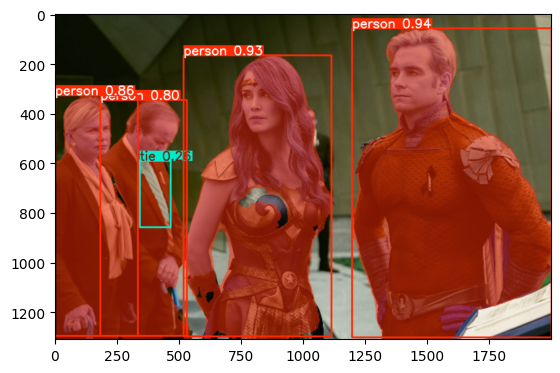

In [40]:
img_result = results_seg[0].plot()

plt.figure()
plt.imshow(img_result)
plt.show()

#### Exercici

En la imatge anterior tenim tant les capses de detecció com les segmentacions:
1. Es demana que mostreu només la segmentació de la persona amb major valor de confiança de la xarxa.
2. Es demana que mostreu per pantalla les coordenades de la capsa de detecció de la corbata.